In [1]:
import time

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))
test_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset((train_set, test_set)),
    batch_size=64,
    shuffle=True)

In [4]:
x = np.array(train_set.train_data)

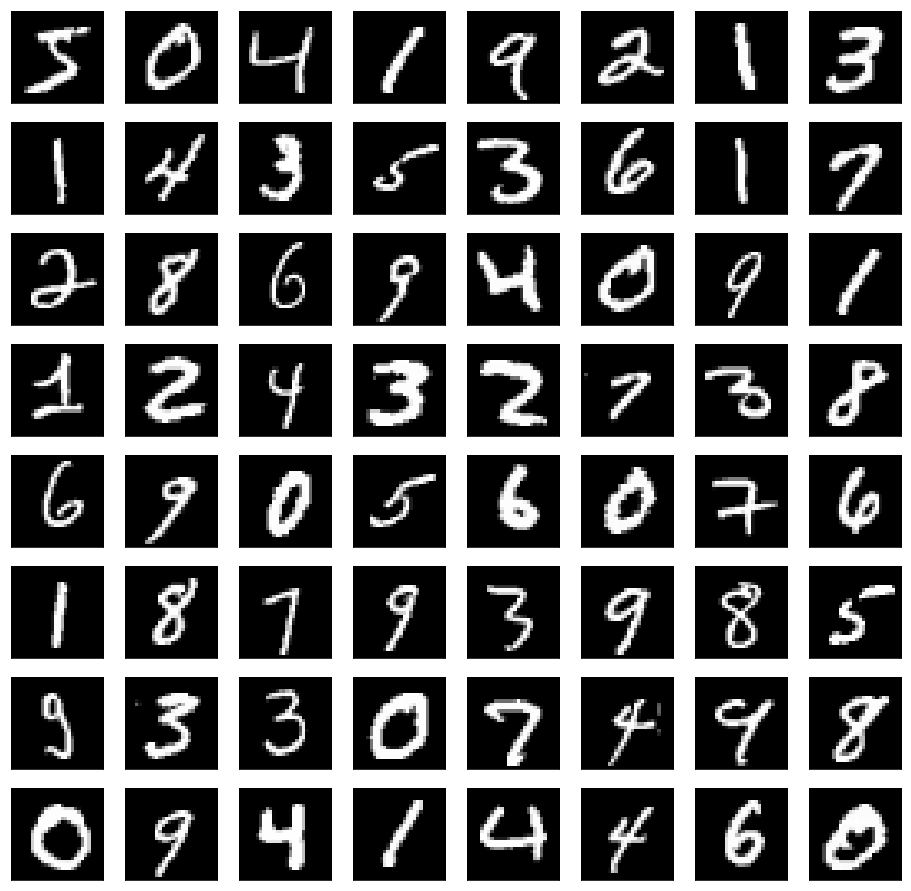

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [7]:
class GAN_:

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.loss = torch.nn.functional.binary_cross_entropy

        self.g = None
        self.d = None

    def fit(self, data_loader, epochs):
        self.g.to(self.device)
        self.d.to(self.device)
        history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
        for epoch in range(1, epochs + 1):
            self.g.train()
            self.d.train()
            start_time = time.time()
            g_loss, d_loss, d_acc = 0, 0, 0
            for real_imgs, _ in data_loader:
                real = torch.Tensor(real_imgs.size(0), 1).fill_(0.9).to(self.device)
                fake = torch.Tensor(real_imgs.size(0), 1).fill_(0.0).to(self.device)
                real_imgs = real_imgs.to(self.device)
                fake_imgs = self.g(
                    torch.Tensor(np.random.normal(0, 1, (real_imgs.size(0), 100))).to(self.device))
                # Train discriminator
                self.d.optimizer.zero_grad()
                real_out = self.d(real_imgs)
                fake_out = self.d(fake_imgs.detach())
                d_loss_ = (self.loss(real_out, real) + self.loss(fake_out, fake)) / 2
                d_loss_.backward()
                self.d.optimizer.step()
                # Train generator
                self.g.optimizer.zero_grad()
                g_loss_ = self.loss(self.d(fake_imgs), real)
                g_loss_.backward()
                self.g.optimizer.step()
                # Calculate metrics for batch
                g_loss += float(g_loss_) * len(real_imgs)
                d_loss += float(d_loss_) * len(real_imgs)
                d_acc += int((real_out >= 0.5).sum()) + int((fake_out < 0.5).sum())
            # Calculate metrics for epoch
            g_loss /= len(data_loader.dataset)
            d_loss /= len(data_loader.dataset)
            d_acc /= 2 * len(data_loader.dataset)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['g_loss'].append(g_loss)
            history['d_loss'].append(d_loss)
            history['d_acc'].append(d_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')

            if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
                fake_imgs = self.g(
                    torch.Tensor(np.random.normal(0, 1, (24, 100))).to(self.device)).detach().cpu()
                plt.figure(figsize=(16, 6))
                for i in range(24):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(fake_imgs[i], cmap=plt.cm.gray)
                    plt.xticks([])
                    plt.yticks([])
                plt.show()

        return history

In [8]:
class GAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Linear(100, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(256, momentum=0.8),
                    torch.nn.Linear(256, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(512, momentum=0.8),
                    torch.nn.Linear(512, 1024),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(1024, momentum=0.8),
                    torch.nn.Linear(1024, 784),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(784, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(512, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(256, 1),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), -1)
                for layer in self.layers:
                    x = layer(x)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [9]:
model = GAN()

[ 1/80] 13.3s - g_loss: 0.9155 - d_loss: 0.5967 - d_acc: 0.7108


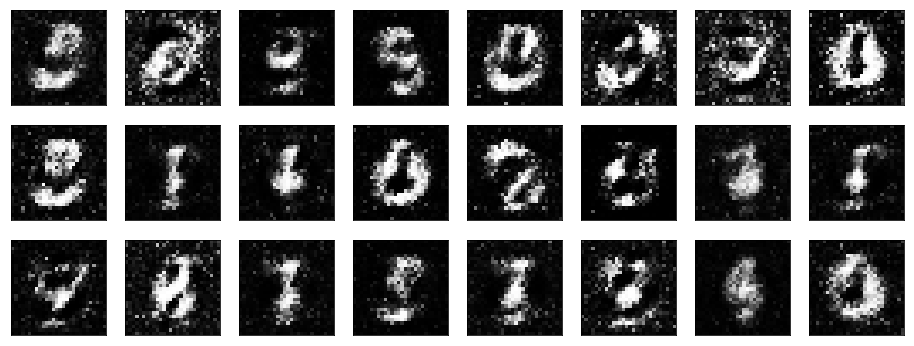

[ 2/80] 12.5s - g_loss: 0.9581 - d_loss: 0.6232 - d_acc: 0.6647
[ 3/80] 12.5s - g_loss: 0.9367 - d_loss: 0.6351 - d_acc: 0.6439
[ 4/80] 12.7s - g_loss: 0.8720 - d_loss: 0.6590 - d_acc: 0.6033
[ 5/80] 12.5s - g_loss: 0.8448 - d_loss: 0.6685 - d_acc: 0.5807
[ 6/80] 12.5s - g_loss: 0.8283 - d_loss: 0.6749 - d_acc: 0.5634
[ 7/80] 12.5s - g_loss: 0.8286 - d_loss: 0.6750 - d_acc: 0.5624
[ 8/80] 12.5s - g_loss: 0.8219 - d_loss: 0.6775 - d_acc: 0.5554
[ 9/80] 12.6s - g_loss: 0.8192 - d_loss: 0.6792 - d_acc: 0.5513
[10/80] 12.5s - g_loss: 0.8132 - d_loss: 0.6808 - d_acc: 0.5450
[11/80] 12.5s - g_loss: 0.8136 - d_loss: 0.6806 - d_acc: 0.5456
[12/80] 12.6s - g_loss: 0.8112 - d_loss: 0.6814 - d_acc: 0.5408
[13/80] 11.9s - g_loss: 0.8082 - d_loss: 0.6813 - d_acc: 0.5414
[14/80] 12.0s - g_loss: 0.8085 - d_loss: 0.6819 - d_acc: 0.5392
[15/80] 12.6s - g_loss: 0.8078 - d_loss: 0.6815 - d_acc: 0.5389
[16/80] 12.6s - g_loss: 0.8080 - d_loss: 0.6816 - d_acc: 0.5393
[17/80] 12.5s - g_loss: 0.8074 - d_loss:

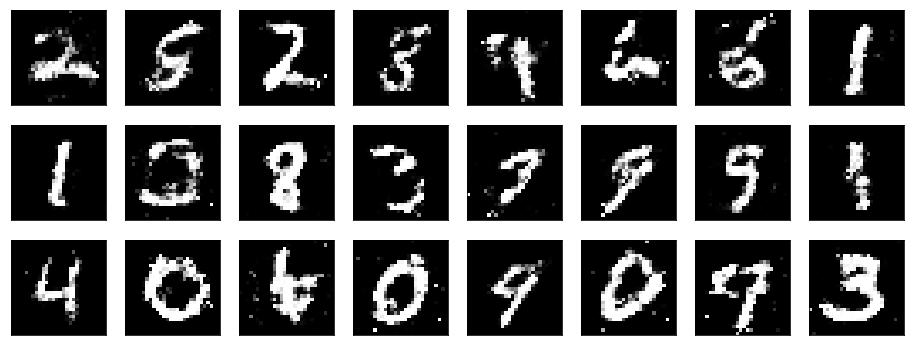

[21/80] 12.4s - g_loss: 0.8034 - d_loss: 0.6828 - d_acc: 0.5339
[22/80] 12.4s - g_loss: 0.8023 - d_loss: 0.6829 - d_acc: 0.5325
[23/80] 12.9s - g_loss: 0.8008 - d_loss: 0.6829 - d_acc: 0.5327
[24/80] 12.9s - g_loss: 0.8014 - d_loss: 0.6829 - d_acc: 0.5296
[25/80] 12.7s - g_loss: 0.8004 - d_loss: 0.6833 - d_acc: 0.5304
[26/80] 12.7s - g_loss: 0.8007 - d_loss: 0.6832 - d_acc: 0.5316
[27/80] 12.6s - g_loss: 0.8003 - d_loss: 0.6830 - d_acc: 0.5303
[28/80] 13.2s - g_loss: 0.8001 - d_loss: 0.6831 - d_acc: 0.5315
[29/80] 13.1s - g_loss: 0.7993 - d_loss: 0.6832 - d_acc: 0.5302
[30/80] 12.9s - g_loss: 0.7995 - d_loss: 0.6832 - d_acc: 0.5305
[31/80] 12.7s - g_loss: 0.7983 - d_loss: 0.6838 - d_acc: 0.5262
[32/80] 13.1s - g_loss: 0.7982 - d_loss: 0.6836 - d_acc: 0.5269
[33/80] 12.4s - g_loss: 0.7980 - d_loss: 0.6837 - d_acc: 0.5268
[34/80] 13.2s - g_loss: 0.7981 - d_loss: 0.6836 - d_acc: 0.5272
[35/80] 12.8s - g_loss: 0.7971 - d_loss: 0.6839 - d_acc: 0.5272
[36/80] 12.8s - g_loss: 0.7962 - d_loss:

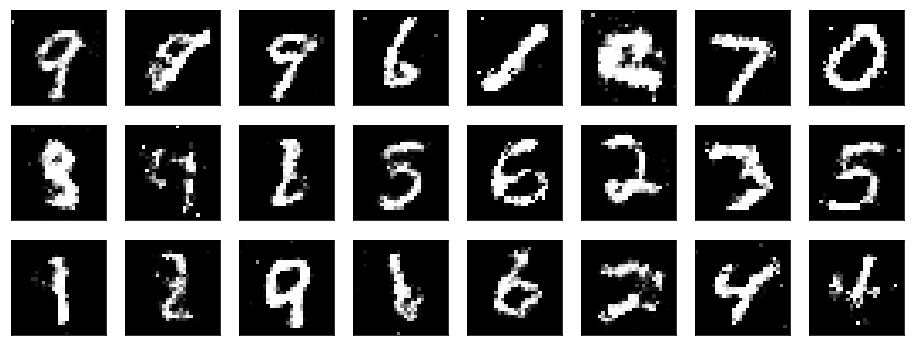

[41/80] 12.9s - g_loss: 0.7961 - d_loss: 0.6843 - d_acc: 0.5231
[42/80] 13.1s - g_loss: 0.7949 - d_loss: 0.6844 - d_acc: 0.5246
[43/80] 13.0s - g_loss: 0.7954 - d_loss: 0.6844 - d_acc: 0.5227
[44/80] 12.9s - g_loss: 0.7942 - d_loss: 0.6850 - d_acc: 0.5215
[45/80] 13.0s - g_loss: 0.7948 - d_loss: 0.6847 - d_acc: 0.5227
[46/80] 12.6s - g_loss: 0.7939 - d_loss: 0.6846 - d_acc: 0.5221
[47/80] 13.1s - g_loss: 0.7945 - d_loss: 0.6846 - d_acc: 0.5224
[48/80] 13.0s - g_loss: 0.7940 - d_loss: 0.6849 - d_acc: 0.5198
[49/80] 12.9s - g_loss: 0.7940 - d_loss: 0.6848 - d_acc: 0.5210
[50/80] 13.0s - g_loss: 0.7944 - d_loss: 0.6842 - d_acc: 0.5238
[51/80] 13.2s - g_loss: 0.7946 - d_loss: 0.6845 - d_acc: 0.5234
[52/80] 12.7s - g_loss: 0.7940 - d_loss: 0.6849 - d_acc: 0.5207
[53/80] 12.8s - g_loss: 0.7943 - d_loss: 0.6848 - d_acc: 0.5220
[54/80] 12.7s - g_loss: 0.7934 - d_loss: 0.6849 - d_acc: 0.5217
[55/80] 12.6s - g_loss: 0.7925 - d_loss: 0.6850 - d_acc: 0.5193
[56/80] 13.1s - g_loss: 0.7928 - d_loss:

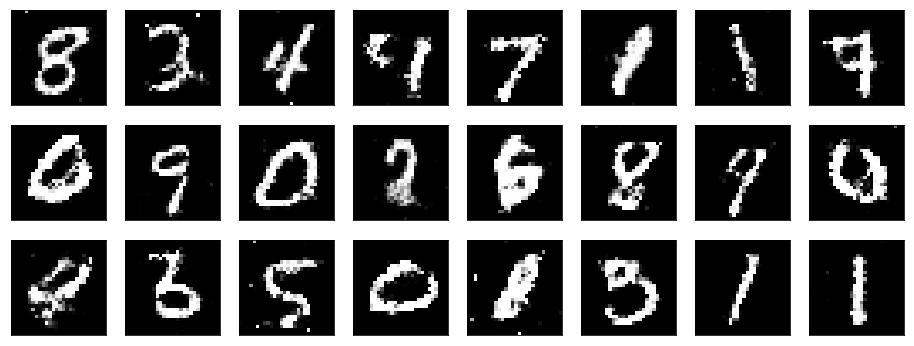

[61/80] 13.0s - g_loss: 0.7938 - d_loss: 0.6851 - d_acc: 0.5194
[62/80] 12.7s - g_loss: 0.7935 - d_loss: 0.6853 - d_acc: 0.5195
[63/80] 12.7s - g_loss: 0.7934 - d_loss: 0.6849 - d_acc: 0.5210
[64/80] 12.6s - g_loss: 0.7927 - d_loss: 0.6851 - d_acc: 0.5201
[65/80] 12.7s - g_loss: 0.7930 - d_loss: 0.6848 - d_acc: 0.5214
[66/80] 12.7s - g_loss: 0.7923 - d_loss: 0.6851 - d_acc: 0.5204
[67/80] 12.6s - g_loss: 0.7918 - d_loss: 0.6855 - d_acc: 0.5174
[68/80] 12.6s - g_loss: 0.7919 - d_loss: 0.6852 - d_acc: 0.5192
[69/80] 12.6s - g_loss: 0.7936 - d_loss: 0.6848 - d_acc: 0.5207
[70/80] 12.7s - g_loss: 0.7922 - d_loss: 0.6856 - d_acc: 0.5171
[71/80] 13.2s - g_loss: 0.7914 - d_loss: 0.6857 - d_acc: 0.5164
[72/80] 12.8s - g_loss: 0.7924 - d_loss: 0.6851 - d_acc: 0.5199
[73/80] 12.9s - g_loss: 0.7924 - d_loss: 0.6853 - d_acc: 0.5171
[74/80] 12.7s - g_loss: 0.7916 - d_loss: 0.6856 - d_acc: 0.5181
[75/80] 12.7s - g_loss: 0.7910 - d_loss: 0.6854 - d_acc: 0.5182
[76/80] 12.6s - g_loss: 0.7923 - d_loss:

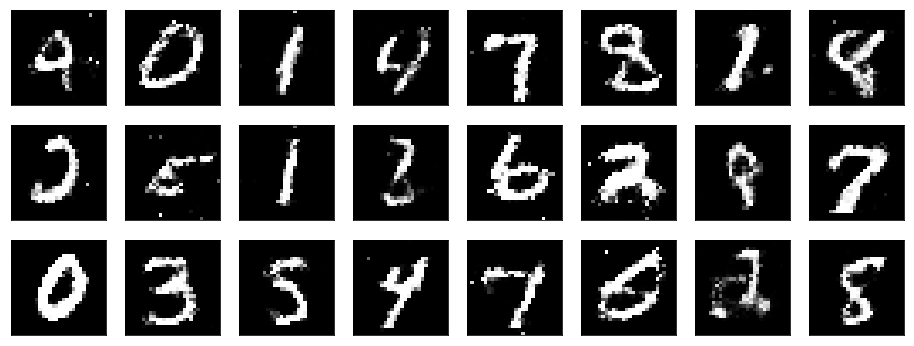

In [10]:
history = model.fit(data_loader, epochs=80)

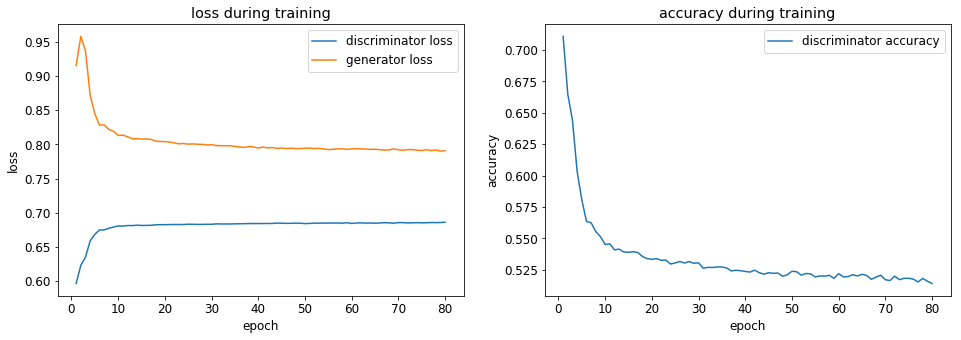

In [11]:
plot_history(history)